# New Measure - Aspirin EC 75mg tablets per 1000 patients

## Rationale

Patients sometimes get prescribed aspirin with a "gastro-resistant" coating (also called enteric coating or EC) in order to protect from the gastro-intestinal side-effects associated with aspirin, by stopping the tablet dissolving in the stomach, and instead dissolving in the higher pH duodenum.

However, [according to the UK Medicines Information Service](https://t.co/3uLdMA8P8A?amp=1), there is only weak evidence to suggest reduced blood loss or decreased gastrointestinal ulceration with EC aspirin, and that it is insufficient to support a clinical benefit over standard release (plain) aspirin.  In addition, there is speculation that enteric coating reduces the anti-platelet effect of aspirin, and thus its efficacy in the prevention of cardiovascular events. The available evidence for this is conflicting. There is a theory of pseudoresistance reflecting delayed and reduced drug absorption with EC aspirin over normal plain aspirin. 

Therefore, EC aspirin should not be routinely used in preference to uncoated aspirin products. Here we will prototype two alternative measures for discussion




## Proposed Measure 1

**Name:** Aspirin enteric-coated 75mg tablets prescribing per 1000 patients

**Description:** Prescribing of aspirin enteric-coated 75mg tablet per 1000 registered patients 

**Why It Matters**: 

Patients sometimes get prescribed aspirin with a "gastro-resistant" coating (also called enteric coating or EC) in order to protect from the gastro-intestinal side-effects associated with aspirin, by stopping the tablet dissolving in the stomach, and instead dissolving in the higher pH duodenum.

However, according to [according to the UK Medicines Information Service](https://t.co/3uLdMA8P8A?amp=1), there is only weak evidence to suggest reduced blood loss or decreased gastrointestinal ulceration with EC aspirin, and that it is insufficient to support a clinical benefit over standard release (plain) aspirin.  In addition, there is speculation that enteric coating reduces the anti-platelet effect of aspirin, and thus its efficacy in the prevention of cardiovascular events. The available evidence for this is conflicting. There is a theory of pseudoresistance reflecting delayed and reduced drug absorption with EC aspirin over normal plain aspirin.

Therefore, EC aspirin should not be routinely used in preference to uncoated aspirin products.


### Numerators and Denominators

Numerator: `bnf_code LIKE '0209000A0%AK' --Aspirin Tab_E/C 75mg`

Denominator: patient list size



## SQL and results

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

In [2]:
#calculate the number of items per 1000 patients for aspirin EC 75mg tabs (and brands)
sql = """
SELECT rx.month, rx.pct, sum(rx.items) as items, total_list_size, 
1000*sum(ieee_divide(rx.items,total_list_size)) as measure --calculates number of items and items per 1000 patients
FROM
hscic.normalised_prescribing_standard as rx
INNER JOIN (
SELECT
  prac.ccg_id as ccg,
  month,
  SUM(total_list_size) AS total_list_size
FROM
  hscic.practice_statistics AS prac_stats
INNER JOIN
  hscic.practices AS prac
ON
prac.code=prac_stats.practice
INNER JOIN
  hscic.ccgs as ccgs
ON
prac.ccg_id = ccgs.code
WHERE
ccgs.org_type = 'CCG'
GROUP BY
  month,
  prac.ccg_id) AS stats --this creates the list size for a CCG, and ensures that only CCGs are included in the data
ON
  rx.month=stats.month
  AND rx.pct=stats.ccg
WHERE 
bnf_code LIKE '0209000A0%AK' --Aspirin Tab_E/C 75mg (brand and generic)
GROUP BY rx.month, rx.pct, stats.total_list_size
ORDER BY month
"""
asp_ec_df = bq.cached_read(sql, csv_path='asp_ec_df.csv', use_cache=True)
asp_ec_df['month'] = asp_ec_df['month'].astype('datetime64[ns]')


## Changes in prescribing levels

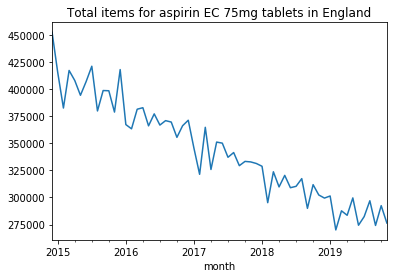

In [3]:
#plot data on graph
asp_ec_df.groupby(["month"])['items'].sum().plot(kind='line', title="Total items for aspirin EC 75mg tablets in England")

This shows that, although reducing, there has been significant prescribing of aspirin EC 75mg tabs in the last five years.

## Modelling for measure

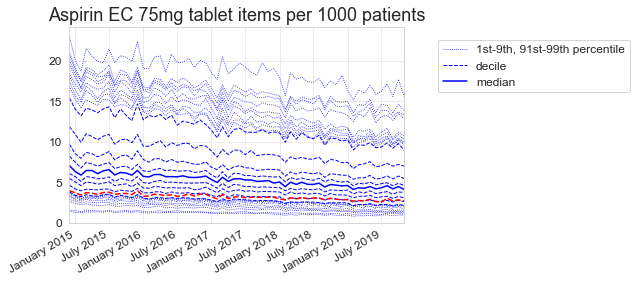

In [4]:
#create sample deciles
charts.deciles_chart(
        asp_ec_df,
        period_column='month',
        column='measure',
        title="Aspirin EC 75mg tablet items per 1000 patients",
        show_outer_percentiles=True)

#add in example CCG (Devon - 15N)
df_subject = asp_ec_df.loc[asp_ec_df['pct'] == '15N']
plt.plot(df_subject['month'], df_subject['measure'], 'r--')
plt.show()

There is significant use in some CCGs, along with significant variation.

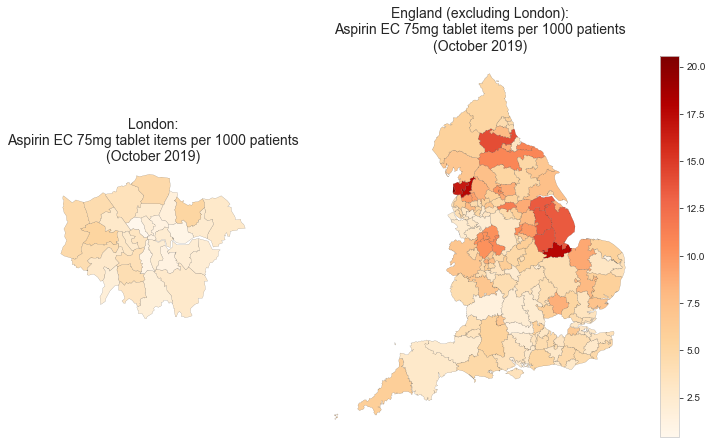

In [5]:
#create choropeth map of aspirin 75mg EC per 1000 patients
plt.figure(figsize=(12, 7)) 
latest_per_1000_df = asp_ec_df.loc[asp_ec_df['month'] == '2019-10-01']
plt = maps.ccg_map(latest_per_1000_df, title="Aspirin EC 75mg tablet items per 1000 patients\n(October 2019)", column='measure', cartogram=False, separate_london=True)
plt.show()

## Proposed Measure 2

**Name:** Aspirin enteric-coated  tablets prescribing as a proprotion of all aspirin tablets

**Description:** Prescribing of aspirin enteric-coated 75mg and 300mg tablet as a proprotion of all aspirin 75mg and 300mg tablets

In [6]:

sql = """
SELECT
  rx.month,
  rx.pct,
  SUM(
  IF
    (bnf_code LIKE '0209000A0%AK'
      OR bnf_code LIKE'0407010B0%A3',
      items,
      0)) AS enteric_coated,
  SUM(
  IF
    (bnf_code LIKE '0209000A0%'
      OR bnf_code LIKE'0407010B0%',
      items,
      0)) AS total_aspirin,
FROM
  hscic.normalised_prescribing_standard AS rx
JOIN
  hscic.ccgs AS ccgs
ON
  rx.pct=ccgs.code
WHERE
  ccgs.org_type='CCG'
GROUP BY
  rx.month,
  rx.pct
ORDER BY
  month
"""
asp_prop_df = bq.cached_read(sql, csv_path='asp_prop_df.csv', use_cache=True)
asp_prop_df['month'] = asp_prop_df['month'].astype('datetime64[ns]')
asp_prop_df.head()

,month,pct,enteric_coated,total_aspirin
0,2010-08-01,05Y,3145,11546
1,2010-08-01,08E,1947,12487
2,2010-08-01,07Y,1521,9404
3,2010-08-01,00L,3843,23669
4,2010-08-01,08X,3526,10848


In [7]:
asp_prop_df["measure_value"] = asp_prop_df["enteric_coated"] / asp_prop_df["total_aspirin"] * 100
asp_prop_df.head()

,month,pct,enteric_coated,total_aspirin,measure_value
0,2010-08-01,05Y,3145,11546,27.238871
1,2010-08-01,08E,1947,12487,15.592216
2,2010-08-01,07Y,1521,9404,16.173969
3,2010-08-01,00L,3843,23669,16.236427
4,2010-08-01,08X,3526,10848,32.503687


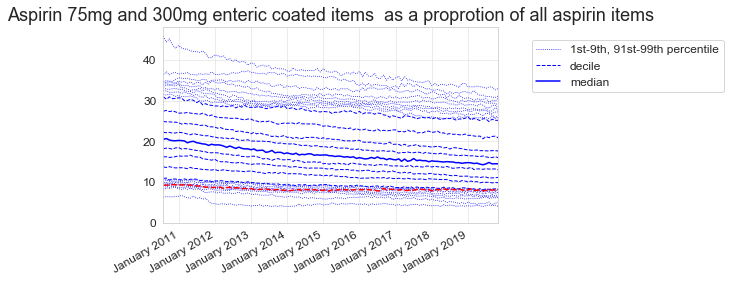

In [8]:
#create sample deciles
charts.deciles_chart(
        asp_prop_df,
        period_column='month',
        column='measure_value',
        title="Aspirin 75mg and 300mg enteric coated items  as a proprotion of all aspirin items",
        show_outer_percentiles=True)

#add in example CCG (Devon - 15N)
df_subject = asp_prop_df.loc[asp_prop_df['pct'] == '15N']
plt.plot(df_subject['month'], df_subject['measure_value'], 'r--')
plt.show()

## Proposed JSON

```{
  "name": "Aspirin 75mg EC tablets",
  "title": [
    "Aspirin 75mg EC tablets prescribing per 1000 patients"
  ],
  "description": [
    "Prescribing of aspirin 75mg EC tablets per 1000 registered patients"
  ],
  "why_it_matters": [
    "<p>Patients sometimes get prescribed aspirin with a 'gastro-resistant' coating (also called enteric coating or EC) in ",
    "order to protect from the gastro-intestinal side-effects associated with aspirin, by stopping the tablet dissolving ",
    "in the stomach, and instead dissolving in the higher pH duodenum.</p>",
    "<p>However, <a href='https://www.sps.nhs.uk/articles/is-there-evidence-to-support-the-use-of-enteric-coated-ec-aspirin-to-reduce-gastrointestinal-side-effects-in-patients-with-cardiovascular-disease/'>  ",
    "according to UKMI</a>, there is only weak evidence to suggest reduced blood loss or decreased GI ulceration ",
    "with EC aspirin, and that it is insufficient to support a clinical benefit over standard release (plain) aspirin. ",
    "In addition, there is speculation that enteric coating reduces the anti-platelet effect of aspirin, and thus its ",
    "efficacy in the prevention of cardiovascular events. The available evidence for this is conflicting. There is a ",
    "theory of pseudoresistance reflecting delayed and reduced drug absorption with EC aspirin over normal plain aspirin.</p>",
    "<p>Therefore, EC aspirin should not be routinely used in preference to uncoated aspirin products.</p>"
  ],
  "numerator_short": "Vitamin B complex items",
  "denominator_short": "1000 patients",
  "url": null,
  "is_percentage": false,
  "is_cost_based": false,
  "low_is_good": true,
  "tags": [
    "core",
    "efficacy",
    "nice"
  ],
  "numerator_type": "bnf_items",
  "numerator_where": [
    "bnf_code LIKE '0209000A0%AK' --Aspirin Tab_E/C 75mg (brand and generic)"
  ],
  "denominator_type": "list_size",
  "date_reviewed": [
    ""
  ],
  "next_review": [
    ""
  ],
  "authored_by": [
    "richard.croker@phc.ox.ac.uk"
  ],
  "checked_by": [
    ""
  ],
  "measure_complexity": [
    "low"
  ],
  "measure_notebook_url": [
    ""
  ]
}```